<a href="https://colab.research.google.com/github/complyservice/Data-science/blob/main/Deteccao_de_cancer_de_mamacom_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Machine Learning para a Detecção do Câncer de Mama

    

A utilização de Machine Learning para a detecção do câncer de mama vem crescendo cada vez mais, e contribuído para diagnósticos mais rápidos e precisos.

De acordo com a Sociedade Brasileira de Mastologia, uma em cada 12 mulheres terá um tumor nas mamas até os 90 anos. Infelizmente, o câncer de mama é a principal causa de morte entre as mulheres, de todos os diferentes tipos de câncer.

In [ ]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

# configurar o notebook
sns.set_style()

In [ ]:

data_path = "https://www.dropbox.com/s/z8nw6pfumdw3bb9/breast-cancer-wisconsin.csv?raw=1" 
df = pd.read_csv(data_path)
df.drop('Unnamed: 32', axis=1, inplace=True)

Análise Exploratória

A primeira coisa que faremos após importar o dataset será examinar as dimensões do DataFrame e as primeiras entradas. Isso possibilitará criar uma consciência situacional inicial a respeito do formato de entrada e da estrutura geral dos dados.

    A coluna id representa o número de identificação.
    A coluna diagnosis é a variável alvo.
        M - Maligno
        B - Benigno
        Uma característica é um número de identificação (ID), outro é o diagnóstico de câncer, e 30 são medidas laboratoriais numéricas. O diagnóstico é codificado como “M” para indicar maligno ou “B” para indicar benigno.


In [ ]:
print("DIMENSOES DO DATAFRAME:")
print("Linhas:\t\t{}".format(df.shape[0]))
print("Linhas:\t\t{}".format(df.shape[1]))

DIMENSOES DO DATAFRAME:
Linhas:		569
Linhas:		32


In [ ]:
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
df.describe()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,5.690000e+02,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,3.037183e+07,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,1.250206e+08,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,8.670000e+03,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,8.692180e+05,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,9.060240e+05,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,8.813129e+06,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,9.113205e+08,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [ ]:
df.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [ ]:
print("Diagnosticos:")
print(df.diagnosis.value_counts()/df.shape[0])


Diagnosticos:
B    0.627417
M    0.372583
Name: diagnosis, dtype: float64


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


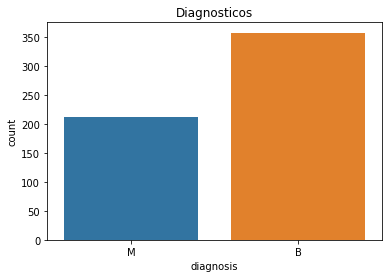

In [ ]:
fig, ax = plt.subplots()
sns.countplot('diagnosis',data = df , ax = ax)
ax.set_title('Diagnosticos')
plt.show()


Atenção em como os valores de algumas variáveis estão mais bem distribuídos em torno de uma média e outras tendem a puxar o histograma para a esquerda.

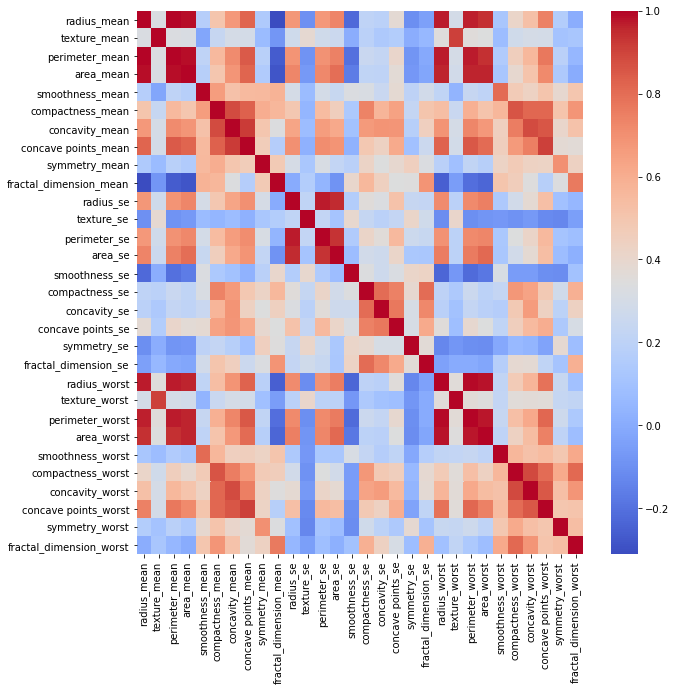

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df.drop('id', axis=1).corr(), cmap='coolwarm', ax=ax)
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  


AttributeError: ignored

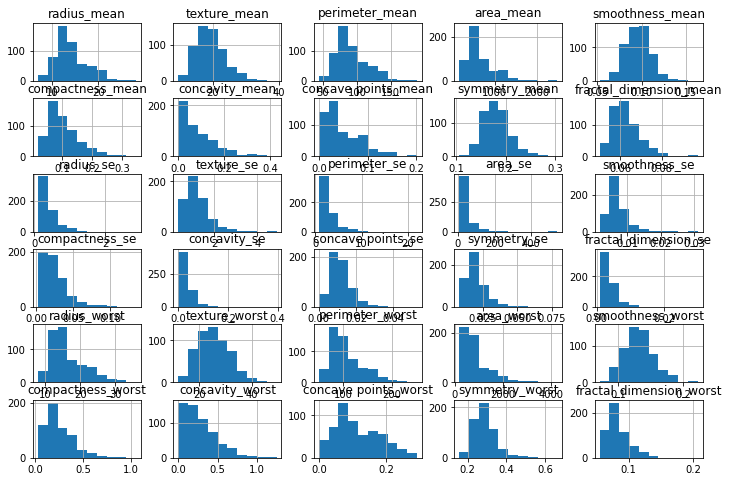

In [ ]:
fix , ax = plt.subplots(figsize = (12,8))
df.drop('id', axis = 1).hist(ax=ax)
plt.tigh_layout()

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
X = df.drop(['diagnosis', 'id'], axis = 1)
y = df['diagnosis']
X = StandardScaler().fit_transform(X)
y = LabelEncoder().fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

Vale destacar que o cálculo utilizar por StandardScaler para calcular os scores é z=x−us, onde u é a média das amostras do conjunto de treino e s é o desvio padrão dessa amostra.

Por fim, antes de construir o modelo de fato, dividimos o dataset entre treino e teste usando o train_test_split, função que facilitar muito o trabalho, e que se encontra em sklearn.model_selection.


Modelo de Machine Learning para detecção do câncer de mama

Este problema de detecção de câncer consiste em classificar corretamente um tumor entre benigno e maligno, ou seja, é necessário que o modelo de Machine Learning dê uma classificação ao ser alimentado com diversas variáveis independentes (features).

Aqui, usarei um modelo do tipo Random Forest (Floresta Aleatória) devido à sua flexibilidade e facilidade de uso (uma vez que funciona muito bem mesmo sem o ajuste nos hiperparâmetros).

In [ ]:
from sklearn.ensemble import RandomForestClassifier
ml_model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', 
                                  random_state = 42)
ml_model.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

O algoritmo Random Forest, que usa métodos ensemble, tem esse nome por que cria uma combinação de várias árvores de decisão - uma "floresta" realmente - verificando qual combinação apresenta melhor desempenho e acurácia.

Vamos dar uma checada no desempenho do modelo quando se depara pela primeira vez com o conjunto de testes.


Desempenho do modelo de detecção de câncer de mama

Cada caso é um caso. Nem sempre uma excelente acurácia vai significar que seu modelo está bom.

Por exemplo, quando se trata de detectar câncer, queremos maximizar o número de verdadeiros positivos e minimizar o número de falsos negativos. No entanto, esta é uma balança difícil de equilibrar, e o trade-off pode ser bem subjetivo inclusive.

Aqui, além da métrica de acurácia vou usar a função classification_report para ver ver o desempenho do modelo sobre as métricas de precisão, recall, f1-score e support.

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
y_pred = ml_model.predict(X_test)
print('[Acurácia] Random Forest:', accuracy_score(y_test, y_pred))
print('\n[Classification Report] Random Forest')
print( classification_report(y_test, y_pred) )

[Acurácia] Random Forest: 0.9473684210526315

[Classification Report] Random Forest
              precision    recall  f1-score   support

           0       0.94      0.97      0.96       106
           1       0.95      0.91      0.93        65

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171



Aparentemente, o modelo está com ótimos valores nas métricas consideradas.  

Eu acho muito interessante você sempre dar uma checada na matriz de confusão. 


In [ ]:
pd.DataFrame(confusion_matrix(y_test, y_pred),
             index=['neg', 'pos'], columns=['pred_neg', 'pred_pos'])

,pred_neg,pred_pos
neg,103,3
pos,6,59


Como você pode confirmar, o modelo classificatório Random Forest foi capaz de atingir uma acurácia superior a 96% e lidou muito bem com ambas as classes.

# New Section

In [ ]:
from google.colab import drive
drive.mount('/content/drive')